Modeling: Light Parametric + Mass Total + Source Parametric
================================================================

To fit a lens model to a dataset, we must perform lens modeling, which uses a `NonLinearSearch` to fit many
different tracers to the dataset.

In this example script, we fit `Imaging` of a strong lens system where:

 - The lens galaxy's light is modeled parametrically as an `EllipticalSersic` and `EllipticalExponential`.
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal` and `ExternalShear`.
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset `light_sersic__mass_sie__source_sersic` `from .fits files, which is the dataset 
we will use to perform lens modeling.

In [2]:
dataset_name = "light_sersic_exp__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

The model-fit also requires a mask defining the regions of the image we fit the lens model to the data.

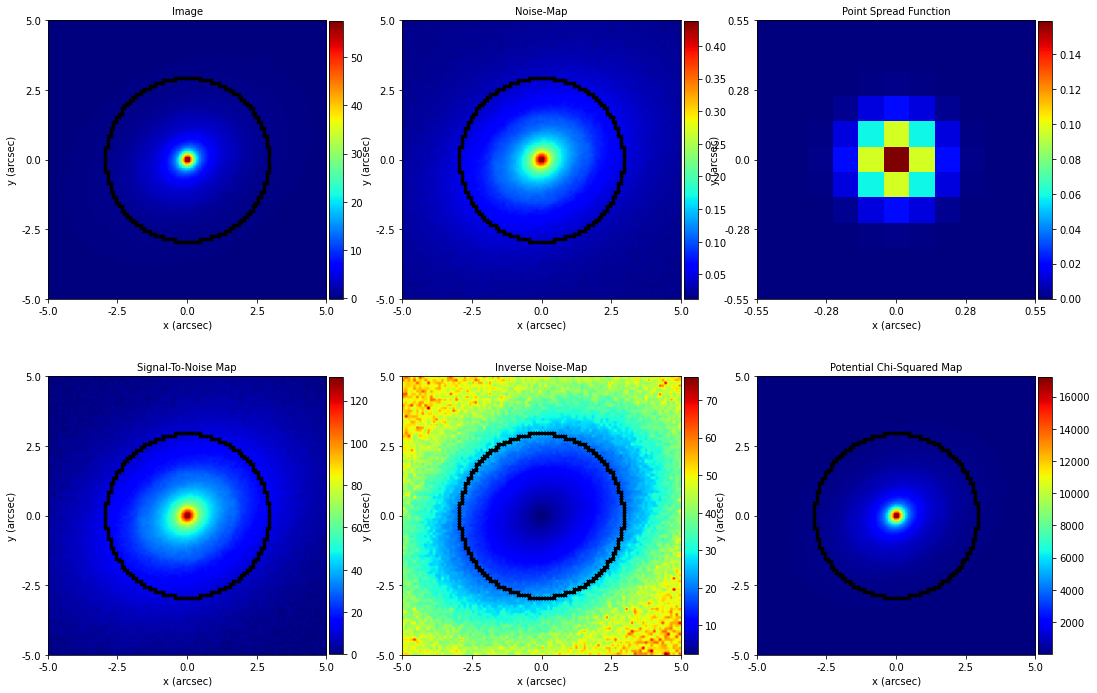

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Phase__

To perform lens modeling, we create a `PhaseImaging` object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.
   
Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens model is:

 - The lens galaxy's light is modeled parametrically as an `EllipticalSersic` and `EllipticalExponential`,
   the centres of which are aligned (11 parameters).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal` and `ExternalShear` (7 parameters).
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic` (7 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=27.

NOTE: By default, **PyAutoLens** assumes the image has been reduced such that the lens galaxy centre is at (0.0", 0.0"),
with the priors on the lens `LightProfile` and `MassProfile` coordinates set accordingly. if for your dataset the lens
is not centred at (0.0", 0.0"), we recommend you reduce your data so it is (see `autolens_workspace/notebooks/preprocess`). 

Alternatively, you can manually override the priors (see `autolens_workspace/notebooks/imaging/modeling/customize/priors.py`).
This aligns the centres of the bulge and disk, so they share identical values during the non-linear search.

In [4]:
bulge = af.PriorModel(al.lp.EllipticalSersic)
disk = af.PriorModel(al.lp.EllipticalExponential)
bulge.centre = disk.centre

lens = al.GalaxyModel(
    redshift=0.5,
    bulge=bulge,
    disk=disk,
    mass=al.mp.EllipticalIsothermal,
    shear=al.mp.ExternalShear,
)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. Below, we specify:
 
 - That a regular `Grid2D` is used to fit create the model-image when fitting the data 
      (see `autolens_workspace/examples/grids.py` for a description of grids).
 - The sub-grid size of this grid.

Different `SettingsPhase` are used in different example model scripts and a full description of all `SettingsPhase` 
can be found in the example script `autolens/workspace/notebooks/imaging/modeling/customize/settings.py` and the following 
chain -> <chain>

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 100 live points.
 - 10 walks, which instructs the 100 live points to sample parameter space more thoroughly before updating.

The script `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches.py` gives a description of the types of
non-linear searches that **PyAutoLens** supports. If you do not know what a `NonLinearSearch` is or how it 
operates, checkout chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/imaging/light_sersic__mass_sie__source_sersic/phase_light[bulge]_mass[sie]_source[bulge]`.

In [6]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", dataset_name),
    name="phase_light[bulge]_mass[sie]_source[bulge]",
    n_live_points=100,
    walks=10,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [7]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and mask to the phase, which will use the `NonLinearSearch` to fit
the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_light[bulge]_mass[sie]_source[bulge]` to see how your fit is doing!

In [8]:
result = phase.run(dataset=imaging, mask=mask)

INFO:root:phase_light[bulge]_mass[sie]_source[bulge] already completed, skipping non-linear search.


The phase above returned a result, which, for example, includes the lens model corresponding to the maximum
log likelihood solution in parameter space.

In [9]:
print(result.max_log_likelihood_instance)

It also contains instances of the maximum log likelihood Tracer and FitImaging, which can be used to visualize
the fit.

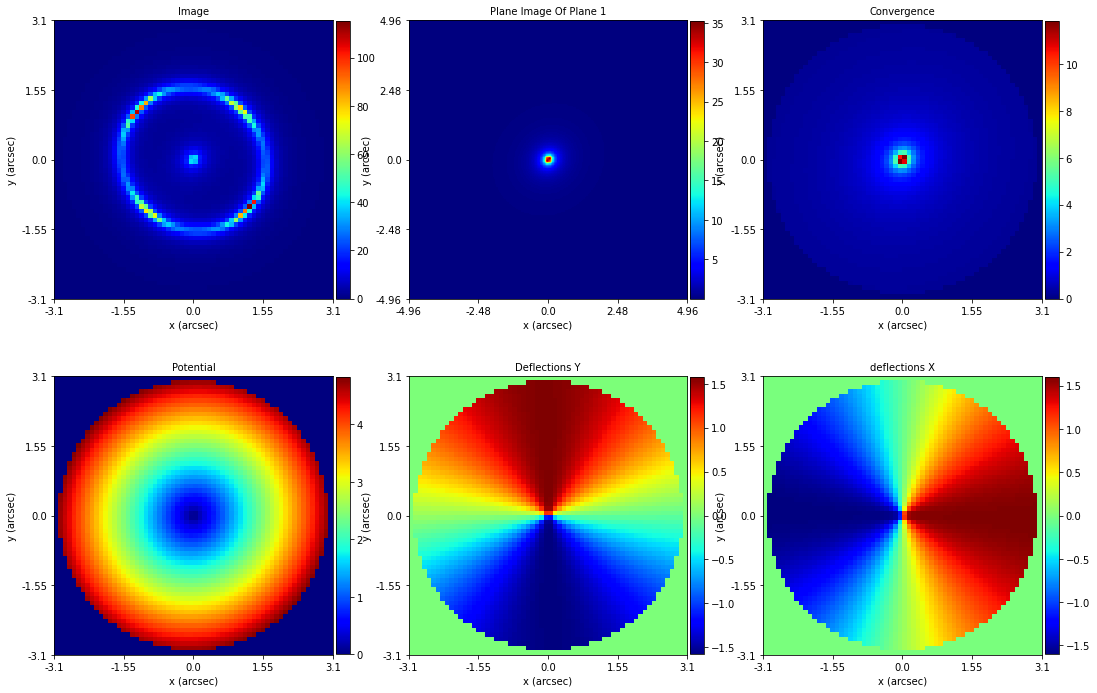

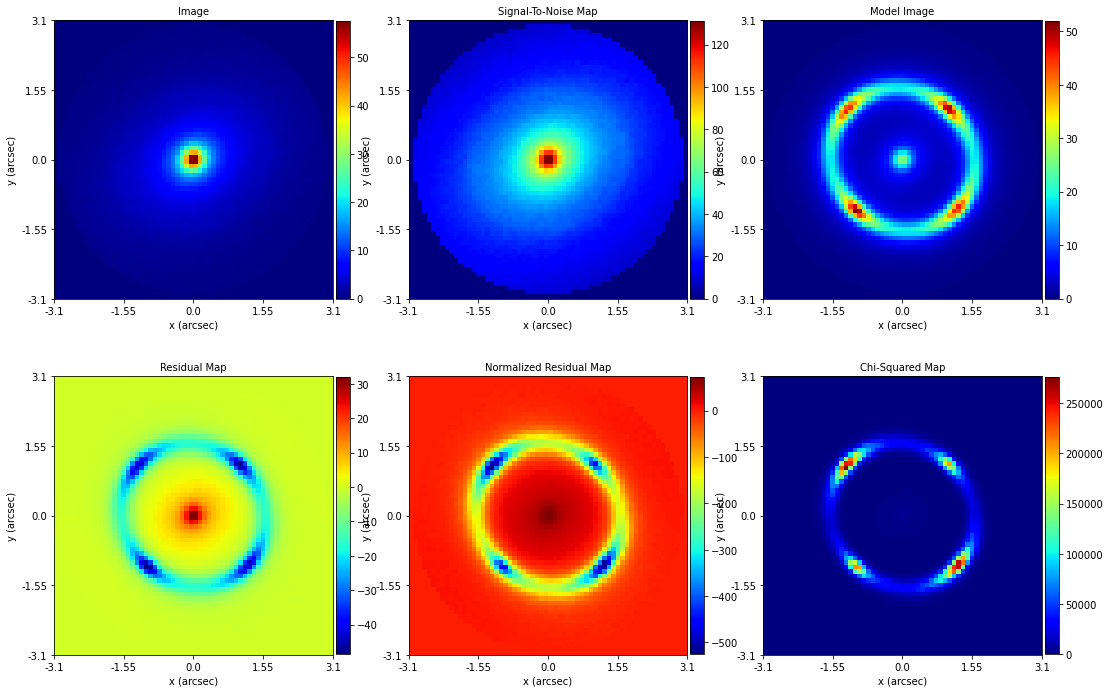

In [10]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()